# Baseline Models

This notebook trains and evaluates baseline models (LSTM, CNN, BiLSTM+Attention).

## Objectives
- Train baseline models on IMDB dataset
- Compare model performance
- Visualize training progress
- Analyze errors


In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from pathlib import Path

from src.data.dataset_loader import load_preprocessed_data
from src.data.preprocess import clean_text, create_vocabulary
from src.models.lstm_model import LSTMModel, BiLSTMWithAttention
from src.models.cnn_model import CNNModel
from src.utils.seed_everything import seed_everything
from src.utils.config_loader import load_config

seed_everything(42)
config = load_config('../config.yaml')


/Users/seunghwanchoi/miniforge3/envs/sentiment-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# For Google Colab - check what GPU you got
try:
    import GPUtil
    GPUs = GPUtil.getGPUs()
    if GPUs:
        for gpu in GPUs:
            print(f"GPU: {gpu.name}")
            print(f"Memory Free: {gpu.memoryFree}MB / {gpu.memoryTotal}MB")
            print(f"GPU Utilization: {gpu.load * 100}%")
except ImportError:
    print("Install GPUtil with: !pip install GPUtil")

Install GPUtil with: !pip install GPUtil


## 1. Load and Prepare Data


In [2]:
# Load preprocessed IMDB data (from notebook 02) - already split into train/val/test
from src.data.dataset_loader import load_preprocessed_data

print("Loading preprocessed IMDB data (train/val/test splits)...")
train_texts, train_labels = load_preprocessed_data('imdb_train', data_dir='../intermediate/data')
val_texts, val_labels = load_preprocessed_data('imdb_val', data_dir='../intermediate/data')
test_texts, test_labels = load_preprocessed_data('imdb_test', data_dir='../intermediate/data')

print(f"✅ Loaded preprocessed data (already split)")
print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")


Loading preprocessed IMDB data (train/val/test splits)...
✅ Loaded preprocessed data (already split)
Train: 35000, Val: 5000, Test: 10000


## 2. Create Vocabulary

Note: Vocabulary creation uses the cleaned/preprocessed texts from the previous step. This vocabulary will be used for all baseline models (LSTM, CNN, etc.).


In [3]:
# Create vocabulary for baseline models
# Use all training data to build comprehensive vocabulary
print("Creating vocabulary from training data...")
vocab = create_vocabulary(train_texts, min_freq=2)
vocab_size = len(vocab)
print(f"✅ Vocabulary size: {vocab_size}")
print(f"Sample vocabulary entries: {list(vocab.items())[:5]}")


Creating vocabulary from training data...
✅ Vocabulary size: 101105
Sample vocabulary entries: [('the', 2), ('a', 3), ('and', 4), ('of', 5), ('to', 6)]


## 3. Train LSTM Model

Using preprocessed data and vocabulary - ready to train!


In [6]:
# Prepare data for baseline models (convert to sequences of word indices)
# Set device: MPS (Metal) for Apple Silicon, CUDA for NVIDIA, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU (no GPU available)")
print(f"Device: {device}")

# Initialize LSTM model
lstm_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    num_classes=2,
    dropout=0.2
).to(device)

print(f"✅ LSTM Model initialized")
print(f"Model parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")


✅ Using Apple Silicon GPU (MPS)
Device: mps
✅ LSTM Model initialized
Model parameters: 10,741,798


### 3.1 Create Dataset and DataLoader

We need to convert text to sequences of word indices using our vocabulary.


In [7]:
# Create a PyTorch Dataset for baseline models
from torch.utils.data import Dataset, DataLoader

class BaselineSentimentDataset(Dataset):
    """Dataset for baseline models that uses word-level vocabulary."""
    
    def __init__(self, texts, labels, vocab, max_length=256):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        self.unk_idx = vocab.get('<UNK>', 1)
        self.pad_idx = vocab.get('<PAD>', 0)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize: convert words to indices
        words = text.lower().split()
        sequence = []
        for word in words:
            sequence.append(self.vocab.get(word, self.unk_idx))
        
        # Pad or truncate to max_length
        if len(sequence) < self.max_length:
            sequence = sequence + [self.pad_idx] * (self.max_length - len(sequence))
        else:
            sequence = sequence[:self.max_length]
        
        return {
            'input_ids': torch.tensor(sequence, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
print("Creating datasets...")
train_dataset = BaselineSentimentDataset(train_texts, train_labels, vocab, max_length=256)
val_dataset = BaselineSentimentDataset(val_texts, val_labels, vocab, max_length=256)
test_dataset = BaselineSentimentDataset(test_texts, test_labels, vocab, max_length=256)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Datasets created: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
print(f"Batch size: {batch_size}")


Creating datasets...
✅ Datasets created: Train=35000, Val=5000, Test=10000
Batch size: 32


### 3.2 Training Setup

Set up optimizer, loss function, and training parameters.

**Note on Epochs:**
- Baseline models (LSTM, CNN) typically need **15-20 epochs** to converge
- Transformers (BERT, etc.) usually only need **3-5 epochs** because:
  - They're pre-trained and fine-tune quickly
  - They have more parameters and learn faster
  - Longer training risks overfitting
  
- We'll use **20 epochs with early stopping** to:
  - Allow the model time to learn
  - Prevent overfitting by stopping when validation performance plateaus


In [8]:
# Setup training components
from torch.optim import Adam
from tqdm import tqdm
import time

optimizer = Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training parameters
# Note: Baseline LSTM models typically need 15-20 epochs to converge
# (vs 3-5 epochs for transformers which train faster)
num_epochs = 20
patience = 5  # Early stopping patience (stop if no improvement for N epochs)
min_delta = 0.0001  # Minimum improvement to consider

print(f"Training parameters:")
print(f"  Epochs: {num_epochs} (baseline models need more epochs than transformers)")
print(f"  Early stopping patience: {patience} epochs")
print(f"  Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  Batch size: {batch_size}")
print(f"  Device: {device}")


Training parameters:
  Epochs: 20 (baseline models need more epochs than transformers)
  Early stopping patience: 5 epochs
  Learning rate: 0.001
  Batch size: 32
  Device: mps


### 3.3 Training Loop

Train the LSTM model with validation monitoring.


In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0
early_stopped = False

print("Starting training...")
print("Note: Baseline models (LSTM/CNN) typically need 15-20 epochs vs 3-5 for transformers\n")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training phase
    lstm_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for batch in train_pbar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = lstm_model(input_ids)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    lstm_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = lstm_model(input_ids)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Update history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping check
    # Check if we improved (either accuracy or loss)
    improved = False
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improved = True
        # Could save model here: torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
    
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        improved = True
    
    # Reset patience counter if we improved (on either metric), otherwise increment
    if improved:
        patience_counter = 0
    else:
        patience_counter += 1
    
    elapsed_time = time.time() - start_time
    
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Best Val Acc: {best_val_acc:.4f} | Best Val Loss: {best_val_loss:.4f}")
    print(f"  Time: {elapsed_time:.2f}s")
    
    if patience_counter >= patience:
        early_stopped = True
        print(f"\n⚠️ Early stopping triggered! No improvement for {patience} epochs.")
        print(f"Stopping training at epoch {epoch+1}")
        break
    
    print()

if not early_stopped:
    print("✅ Training complete! Reached maximum epochs.")
else:
    print(f"✅ Training stopped early at epoch {epoch+1} (best val acc: {best_val_acc:.4f})")


Starting training...
Note: Baseline models (LSTM/CNN) typically need 15-20 epochs vs 3-5 for transformers



Epoch 1/20 [Train]:   3%|▎         | 35/1094 [00:03<01:58,  8.91it/s, loss=0.6742, acc=0.5036]


KeyboardInterrupt: 

### 3.4 Evaluate on Test Set

Evaluate the trained model on the test set.


In [10]:
# Evaluate on test set
lstm_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Evaluating on test set")
    for batch in test_pbar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = lstm_model(input_ids)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_acc = test_correct / test_total

print(f"\n📊 Test Set Results:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix
print(f"\n📈 Detailed Metrics:")
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Positive']))


Evaluating on test set:  22%|██▏       | 70/313 [00:02<00:07, 32.97it/s]


KeyboardInterrupt: 

### 3.5 Visualize Training History

Plot training curves to see how the model learned.


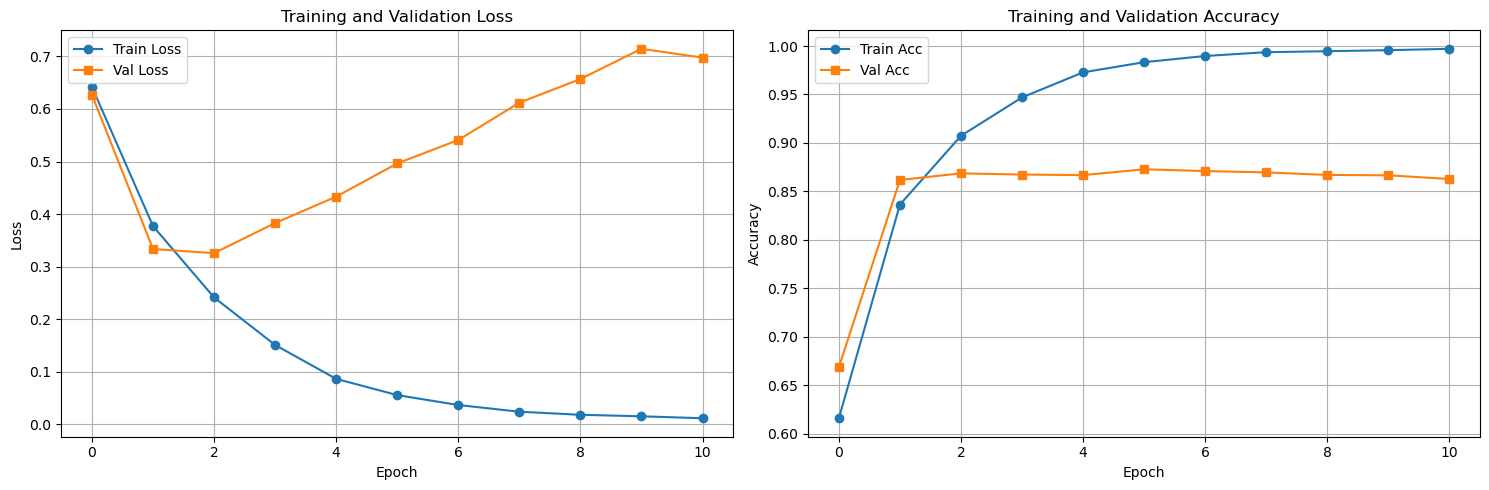

✅ Training plots saved to ../experiments/plots/lstm_training_history.png


In [42]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training plots saved to ../experiments/plots/lstm_training_history.png")


## 3.5 Save Baseline LSTM Results

Save baseline results for comparison with hyperparameter tuning results.


In [43]:
# Save baseline LSTM configuration and results
lstm_baseline_config = {
    'learning_rate': 0.001,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.2,
    'embedding_dim': 100,
    'batch_size': 32,
    'max_length': 256
}

lstm_baseline_results = {
    'test_accuracy': test_acc,
    'test_loss': avg_test_loss,
    'best_val_accuracy': best_val_acc,
    'best_val_loss': best_val_loss,
    'final_epoch': len(history['val_acc'])
}

print("📊 Baseline LSTM Configuration:")
for key, value in lstm_baseline_config.items():
    print(f"  {key}: {value}")

print("\n📊 Baseline LSTM Results:")
for key, value in lstm_baseline_results.items():
    print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

print("\n✅ Baseline saved for comparison")


📊 Baseline LSTM Configuration:
  learning_rate: 0.001
  hidden_dim: 128
  num_layers: 2
  dropout: 0.2
  embedding_dim: 100
  batch_size: 32
  max_length: 256

📊 Baseline LSTM Results:
  test_accuracy: 0.8627
  test_loss: 0.6957
  best_val_accuracy: 0.8728
  best_val_loss: 51.1293
  final_epoch: 11

✅ Baseline saved for comparison


## 3.6 LSTM Hyperparameter Tuning

Tune hyperparameters following ground rules:
- Fixed seed + single validation set
- Early stop on val metric (patience 3-5)
- Save best weights
- 2-3 epochs for scouting runs
- Full training only for finalists
- Gradient clipping (1.0) to prevent bad LRs from nuking runs


In [44]:
# Set fixed seed for reproducibility (already done at top, but ensuring consistency)
seed_everything(42)
print("✅ Seed fixed to 42 for hyperparameter tuning")

# Use fixed validation set (already split, so we're good)
print(f"✅ Using fixed validation set: {len(val_texts)} samples")

# Define hyperparameter search space for LSTM
hyperparameter_space = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.002, 0.005],
    'hidden_dim': [64, 96, 128, 192, 256],
    'num_layers': [1, 2, 3],
    'dropout': [0.1, 0.2, 0.3, 0.4]
}

print("\n🔍 Hyperparameter Search Space:")
for param, values in hyperparameter_space.items():
    print(f"  {param}: {values}")

# Calculate total combinations
total_combinations = 1
for values in hyperparameter_space.values():
    total_combinations *= len(values)
print(f"\n📊 Total combinations: {total_combinations}")
print("⚠️ This is too many for exhaustive search, will use random/grid sampling")


✅ Seed fixed to 42 for hyperparameter tuning
✅ Using fixed validation set: 5000 samples

🔍 Hyperparameter Search Space:
  learning_rate: [0.0001, 0.0005, 0.001, 0.002, 0.005]
  hidden_dim: [64, 96, 128, 192, 256]
  num_layers: [1, 2, 3]
  dropout: [0.1, 0.2, 0.3, 0.4]

📊 Total combinations: 300
⚠️ This is too many for exhaustive search, will use random/grid sampling


### 3.6.1 Create Training Function with Ground Rules

Training function with gradient clipping, early stopping, and best weight saving.


In [45]:
import copy
import os

def train_lstm_with_config(config, train_loader, val_loader, device, 
                          scouting_epochs=3, full_epochs=20, 
                          patience=4, gradient_clip=1.0, 
                          save_best=True, run_name=""):
    """
    Train LSTM with given hyperparameters following ground rules.
    
    Args:
        config: Dict with hyperparameters (learning_rate, hidden_dim, num_layers, dropout)
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        device: Torch device
        scouting_epochs: Number of epochs for scouting run (2-3)
        full_epochs: Number of epochs for full training
        patience: Early stopping patience (3-5)
        gradient_clip: Gradient clipping value
        save_best: Whether to save best weights
        run_name: Name for saving weights
    
    Returns:
        Dictionary with training results
    """
    # Initialize model with config
    model = LSTMModel(
        vocab_size=vocab_size,
        embedding_dim=100,  # Fixed for now
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers'],
        num_classes=2,
        dropout=config['dropout']
    ).to(device)
    
    optimizer = Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    
    # Determine if this is a scouting run or full training
    is_scouting = scouting_epochs < full_epochs
    max_epochs = scouting_epochs if is_scouting else full_epochs
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            # GRADIENT CLIPPING (Ground Rule)
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Early stopping check (Ground Rule)
        improved = False
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            improved = True
            # Save best weights (Ground Rule)
            if save_best:
                best_weights = copy.deepcopy(model.state_dict())
        
        if val_loss < best_val_loss - 0.0001:
            best_val_loss = avg_val_loss
            improved = True
        
        if improved:
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            break
    
    # Load best weights if saved
    if best_weights is not None and save_best:
        model.load_state_dict(best_weights)
    
    return {
        'config': config,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_loss,
        'final_val_acc': val_acc,
        'final_val_loss': avg_val_loss,
        'epochs_trained': len(history['val_acc']),
        'history': history,
        'model_state': model.state_dict() if save_best else None
    }

print("✅ Training function created with ground rules:")
print("  ✓ Gradient clipping (1.0)")
print("  ✓ Early stopping (patience 3-5)")
print("  ✓ Best weight saving")
print("  ✓ Scouting vs full training modes")


✅ Training function created with ground rules:
  ✓ Gradient clipping (1.0)
  ✓ Early stopping (patience 3-5)
  ✓ Best weight saving
  ✓ Scouting vs full training modes


### 3.6.2 Scouting Runs (2-3 Epochs)

Quick passes to identify promising configurations.


In [46]:
# Create a sampled set of configurations for scouting
# Using a reduced search space for efficiency
import random
random.seed(42)

# Sample configurations strategically (focus on promising regions)
scout_configs = [
    # Around baseline config
    {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2},
    {'learning_rate': 0.0005, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2},
    {'learning_rate': 0.002, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2},
    
    # Vary hidden dimension
    {'learning_rate': 0.001, 'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.2},
    {'learning_rate': 0.001, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.2},
    
    # Vary layers
    {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.2},
    {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.2},
    
    # Vary dropout
    {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1},
    {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3},
    {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.4},
    
    # Combine variations
    {'learning_rate': 0.0005, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.3},
    {'learning_rate': 0.002, 'hidden_dim': 96, 'num_layers': 1, 'dropout': 0.2},
]

print(f"🔍 Running {len(scout_configs)} scouting runs (3 epochs each)...")
print("This will take ~{:.1f} minutes per config".format(2.5))

scouting_results = []
for i, config in enumerate(scout_configs, 1):
    print(f"\n{'='*60}")
    print(f"Scouting Run {i}/{len(scout_configs)}")
    print(f"Config: {config}")
    print(f"{'='*60}")
    
    result = train_lstm_with_config(
        config=config,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        scouting_epochs=3,
        full_epochs=20,
        patience=4,
        gradient_clip=1.0,
        save_best=True,
        run_name=f"scout_{i}"
    )
    
    result['run_id'] = i
    scouting_results.append(result)
    
    print(f"✅ Best Val Acc: {result['best_val_acc']:.4f} | Epochs: {result['epochs_trained']}")

print("\n" + "="*60)
print("✅ Scouting runs complete!")
print("="*60)


🔍 Running 12 scouting runs (3 epochs each)...
This will take ~2.5 minutes per config

Scouting Run 1/12
Config: {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2}
✅ Best Val Acc: 0.8656 | Epochs: 3

Scouting Run 2/12
Config: {'learning_rate': 0.0005, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2}
✅ Best Val Acc: 0.8442 | Epochs: 3

Scouting Run 3/12
Config: {'learning_rate': 0.002, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2}
✅ Best Val Acc: 0.8238 | Epochs: 3

Scouting Run 4/12
Config: {'learning_rate': 0.001, 'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.2}
✅ Best Val Acc: 0.8528 | Epochs: 3

Scouting Run 5/12
Config: {'learning_rate': 0.001, 'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.2}
✅ Best Val Acc: 0.5558 | Epochs: 3

Scouting Run 6/12
Config: {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.2}
✅ Best Val Acc: 0.8460 | Epochs: 3

Scouting Run 7/12
Config: {'learning_rate': 0.001, 'hidden_dim': 128, 'num_layer

### 3.6.3 Analyze Scouting Results and Identify Finalists


In [47]:
# Analyze scouting results
scout_df = pd.DataFrame([
    {
        'Run': r['run_id'],
        'LR': r['config']['learning_rate'],
        'Hidden': r['config']['hidden_dim'],
        'Layers': r['config']['num_layers'],
        'Dropout': r['config']['dropout'],
        'Val Acc': r['best_val_acc'],
        'Val Loss': r['best_val_loss'],
        'Epochs': r['epochs_trained']
    }
    for r in scouting_results
])

# Sort by validation accuracy
scout_df = scout_df.sort_values('Val Acc', ascending=False)

print("📊 Scouting Results (sorted by Val Accuracy):")
print(scout_df.to_string(index=False))

# Compare with baseline
baseline_val_acc = lstm_baseline_results['best_val_accuracy']
print(f"\n📊 Baseline Val Accuracy: {baseline_val_acc:.4f}")
print(f"📊 Best Scouting Val Accuracy: {scout_df['Val Acc'].max():.4f}")
improvement = scout_df['Val Acc'].max() - baseline_val_acc
print(f"📊 Improvement: {improvement:+.4f}")

# Identify finalists (top N or those better than baseline)
top_n = 3
finalists = scout_df.head(top_n)
print(f"\n🏆 Top {top_n} Finalists Selected for Full Training:")
print(finalists[['Run', 'LR', 'Hidden', 'Layers', 'Dropout', 'Val Acc']].to_string(index=False))


📊 Scouting Results (sorted by Val Accuracy):
 Run     LR  Hidden  Layers  Dropout  Val Acc  Val Loss  Epochs
   7 0.0010     128       3      0.2   0.8660  0.610681       3
   1 0.0010     128       2      0.2   0.8656  0.493836       3
  12 0.0020      96       1      0.2   0.8596  0.484150       3
  10 0.0010     128       2      0.4   0.8532  0.596764       3
   4 0.0010      96       2      0.2   0.8528  0.657029       3
   9 0.0010     128       2      0.3   0.8476  0.680624       3
   6 0.0010     128       1      0.2   0.8460  0.600206       3
   2 0.0005     128       2      0.2   0.8442  0.537955       3
   8 0.0010     128       2      0.1   0.8390  0.491823       3
   3 0.0020     128       2      0.2   0.8238  0.698444       3
  11 0.0005     192       2      0.3   0.8160  0.649766       3
   5 0.0010     192       2      0.2   0.5558  0.687087       3

📊 Baseline Val Accuracy: 0.8728
📊 Best Scouting Val Accuracy: 0.8660
📊 Improvement: -0.0068

🏆 Top 3 Finalists Selected fo

### 3.6.4 Full Training on Finalists

Train finalist configurations with full epochs (20) to get final results.


In [ ]:
# Run full training on finalists
print(f"🚀 Running full training on {len(finalists)} finalists (20 epochs max)...")
print("This will take longer but gives final results\n")

final_results = []
for idx, row in finalists.iterrows():
    run_id = int(row['Run'])
    config = {
        'learning_rate': row['LR'],
        'hidden_dim': int(row['Hidden']),
        'num_layers': int(row['Layers']),
        'dropout': row['Dropout']
    }
    
    print(f"\n{'='*60}")
    print(f"Full Training - Finalist {run_id}")
    print(f"Config: {config}")
    print(f"{'='*60}")
    
    result = train_lstm_with_config(
        config=config,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        scouting_epochs=3,
        full_epochs=20,
        patience=4,
        gradient_clip=1.0,
        save_best=True,
        run_name=f"finalist_{run_id}"
    )
    
    result['run_id'] = run_id
    final_results.append(result)
    
    print(f"✅ Best Val Acc: {result['best_val_acc']:.4f} | Epochs: {result['epochs_trained']}")

print("\n" + "="*60)
print("✅ Full training complete!")
print("="*60)


### 3.6.5 Evaluate Best Model on Test Set


In [ ]:
# Find best configuration from final results
best_result = max(final_results, key=lambda x: x['best_val_acc'])
best_config = best_result['config']

print("🏆 Best Configuration Found:")
for key, value in best_config.items():
    print(f"  {key}: {value}")
print(f"  Best Val Accuracy: {best_result['best_val_acc']:.4f}")

# Initialize and load best model
best_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=best_config['hidden_dim'],
    num_layers=best_config['num_layers'],
    num_classes=2,
    dropout=best_config['dropout']
).to(device)

if best_result['model_state'] is not None:
    best_model.load_state_dict(best_result['model_state'])
    print("✅ Loaded best weights from training")

# Evaluate on test set
best_model.eval()
test_loss_tuned = 0.0
test_correct_tuned = 0
test_total_tuned = 0
all_predictions_tuned = []
all_labels_tuned = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Evaluating tuned model on test set")
    for batch in test_pbar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = best_model(input_ids)
        loss = criterion(outputs, labels)
        
        test_loss_tuned += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct_tuned += (predictions == labels).sum().item()
        test_total_tuned += labels.size(0)
        
        all_predictions_tuned.extend(predictions.cpu().numpy())
        all_labels_tuned.extend(labels.cpu().numpy())

avg_test_loss_tuned = test_loss_tuned / len(test_loader)
test_acc_tuned = test_correct_tuned / test_total_tuned

print(f"\n📊 Tuned Model Test Set Results:")
print(f"  Test Loss: {avg_test_loss_tuned:.4f}")
print(f"  Test Accuracy: {test_acc_tuned:.4f} ({test_correct_tuned}/{test_total_tuned})")


### 3.6.6 Compare Baseline vs Tuned LSTM


In [ ]:
# Compare baseline vs tuned
comparison_tuning = pd.DataFrame({
    'Model': ['Baseline LSTM', 'Tuned LSTM'],
    'Test Accuracy': [lstm_baseline_results['test_accuracy'], test_acc_tuned],
    'Test Loss': [lstm_baseline_results['test_loss'], avg_test_loss_tuned],
    'Val Accuracy': [lstm_baseline_results['best_val_accuracy'], best_result['best_val_acc']],
    'Learning Rate': [lstm_baseline_config['learning_rate'], best_config['learning_rate']],
    'Hidden Dim': [lstm_baseline_config['hidden_dim'], best_config['hidden_dim']],
    'Layers': [lstm_baseline_config['num_layers'], best_config['num_layers']],
    'Dropout': [lstm_baseline_config['dropout'], best_config['dropout']]
})

print("📊 Baseline vs Tuned LSTM Comparison:\n")
print(comparison_tuning.to_string(index=False))

# Calculate improvement
test_improvement = test_acc_tuned - lstm_baseline_results['test_accuracy']
val_improvement = best_result['best_val_acc'] - lstm_baseline_results['best_val_accuracy']

print(f"\n📈 Improvements:")
print(f"  Test Accuracy: {test_improvement:+.4f} ({test_improvement*100:+.2f}%)")
print(f"  Val Accuracy: {val_improvement:+.4f} ({val_improvement*100:+.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test accuracy comparison
axes[0].bar(['Baseline', 'Tuned'], 
            [lstm_baseline_results['test_accuracy'], test_acc_tuned],
            color=['#3498db', '#2ecc71'])
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Baseline vs Tuned: Test Accuracy')
axes[0].set_ylim([0, 1])
for i, v in enumerate([lstm_baseline_results['test_accuracy'], test_acc_tuned]):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Validation accuracy during training
axes[1].plot(range(1, len(history['val_acc']) + 1), history['val_acc'], 
            label='Baseline', marker='o', color='#3498db')
axes[1].plot(range(1, len(best_result['history']['val_acc']) + 1), 
            best_result['history']['val_acc'],
            label='Tuned', marker='s', color='#2ecc71')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy: Baseline vs Tuned')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/lstm_tuning_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison plots saved to ../experiments/plots/lstm_tuning_comparison.png")


## 4. Train CNN Model

Now let's train a CNN-based baseline model for comparison. CNNs use convolutional filters to capture local patterns in text.


In [11]:
# Initialize CNN model
# CNN uses multiple filter sizes (3, 4, 5) to capture different n-gram patterns
cnn_model = CNNModel(
    vocab_size=vocab_size,
    embedding_dim=100,
    num_filters=100,
    filter_sizes=[3, 4, 5],  # Capture 3-gram, 4-gram, 5-gram patterns
    num_classes=2,
    dropout=0.5
).to(device)

print(f"✅ CNN Model initialized")
print(f"Model parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(f"Filter sizes: [3, 4, 5] - capturing different n-gram patterns")


✅ CNN Model initialized
Model parameters: 10,231,402
Filter sizes: [3, 4, 5] - capturing different n-gram patterns


### 4.1 Training Setup for CNN


In [12]:
# Setup training components for CNN
optimizer_cnn = Adam(cnn_model.parameters(), lr=0.001)
criterion_cnn = nn.CrossEntropyLoss()

# Training parameters (same as LSTM)
num_epochs_cnn = 20
patience_cnn = 5
min_delta_cnn = 0.0001

print(f"CNN Training parameters:")
print(f"  Epochs: {num_epochs_cnn}")
print(f"  Early stopping patience: {patience_cnn} epochs")
print(f"  Learning rate: {optimizer_cnn.param_groups[0]['lr']}")
print(f"  Batch size: {batch_size}")
print(f"  Device: {device}")


CNN Training parameters:
  Epochs: 20
  Early stopping patience: 5 epochs
  Learning rate: 0.001
  Batch size: 32
  Device: mps


### 4.2 CNN Training Loop


In [13]:
# CNN Training history
history_cnn = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc_cnn = 0.0
best_val_loss_cnn = float('inf')
patience_counter_cnn = 0
early_stopped_cnn = False

print("Starting CNN training...\n")

for epoch in range(num_epochs_cnn):
    start_time = time.time()
    
    # Training phase
    cnn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs_cnn} [Train]")
    for batch in train_pbar:
        optimizer_cnn.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = cnn_model(input_ids)
        loss = criterion_cnn(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer_cnn.step()
        
        # Statistics
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    cnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs_cnn} [Val]")
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = cnn_model(input_ids)
            loss = criterion_cnn(outputs, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Update history
    history_cnn['train_loss'].append(avg_train_loss)
    history_cnn['train_acc'].append(train_acc)
    history_cnn['val_loss'].append(avg_val_loss)
    history_cnn['val_acc'].append(val_acc)
    
    # Early stopping check
    improved = False
    if val_acc > best_val_acc_cnn:
        best_val_acc_cnn = val_acc
        improved = True
    
    if val_loss < best_val_loss_cnn - min_delta_cnn:
        best_val_loss_cnn = val_loss
        improved = True
    
    # Reset patience counter if we improved, otherwise increment
    if improved:
        patience_counter_cnn = 0
    else:
        patience_counter_cnn += 1
    
    elapsed_time = time.time() - start_time
    
    print(f"\nEpoch {epoch+1}/{num_epochs_cnn} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Best Val Acc: {best_val_acc_cnn:.4f} | Best Val Loss: {best_val_loss_cnn:.4f}")
    print(f"  Time: {elapsed_time:.2f}s")
    
    if patience_counter_cnn >= patience_cnn:
        early_stopped_cnn = True
        print(f"\n⚠️ Early stopping triggered! No improvement for {patience_cnn} epochs.")
        print(f"Stopping training at epoch {epoch+1}")
        break
    
    print()

if not early_stopped_cnn:
    print("✅ CNN Training complete! Reached maximum epochs.")
else:
    print(f"✅ CNN Training stopped early at epoch {epoch+1} (best val acc: {best_val_acc_cnn:.4f})")


Starting CNN training...



Epoch 1/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 58.31it/s, loss=0.6342, acc=0.7912]



Epoch 1/20 Summary:
  Train Loss: 0.6258 | Train Acc: 0.6580
  Val Loss: 0.4547 | Val Acc: 0.7912
  Best Val Acc: 0.7912 | Best Val Loss: 71.3922
  Time: 787.61s



Epoch 2/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 62.27it/s, loss=0.7293, acc=0.8210]



Epoch 2/20 Summary:
  Train Loss: 0.4849 | Train Acc: 0.7649
  Val Loss: 0.3936 | Val Acc: 0.8210
  Best Val Acc: 0.8210 | Best Val Loss: 61.7955
  Time: 789.80s



Epoch 3/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 63.42it/s, loss=0.7196, acc=0.8564]



Epoch 3/20 Summary:
  Train Loss: 0.3841 | Train Acc: 0.8295
  Val Loss: 0.3251 | Val Acc: 0.8564
  Best Val Acc: 0.8564 | Best Val Loss: 51.0478
  Time: 793.84s



Epoch 4/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 61.19it/s, loss=0.6483, acc=0.8646]



Epoch 4/20 Summary:
  Train Loss: 0.2922 | Train Acc: 0.8781
  Val Loss: 0.3191 | Val Acc: 0.8646
  Best Val Acc: 0.8646 | Best Val Loss: 50.0967
  Time: 3003.36s



Epoch 5/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 60.95it/s, loss=0.5103, acc=0.8662]



Epoch 5/20 Summary:
  Train Loss: 0.2071 | Train Acc: 0.9170
  Val Loss: 0.3389 | Val Acc: 0.8662
  Best Val Acc: 0.8662 | Best Val Loss: 50.0967
  Time: 794.69s



Epoch 6/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 65.63it/s, loss=0.6339, acc=0.8464]



Epoch 6/20 Summary:
  Train Loss: 0.1377 | Train Acc: 0.9475
  Val Loss: 0.4502 | Val Acc: 0.8464
  Best Val Acc: 0.8662 | Best Val Loss: 50.0967
  Time: 789.64s



Epoch 7/20 [Val]: 100%|██████████| 157/157 [01:41<00:00,  1.55it/s, loss=0.4361, acc=0.8582]



Epoch 7/20 Summary:
  Train Loss: 0.0886 | Train Acc: 0.9667
  Val Loss: 0.5099 | Val Acc: 0.8582
  Best Val Acc: 0.8662 | Best Val Loss: 50.0967
  Time: 2972.34s



Epoch 8/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 67.14it/s, loss=0.5332, acc=0.8564]



Epoch 8/20 Summary:
  Train Loss: 0.0607 | Train Acc: 0.9781
  Val Loss: 0.6061 | Val Acc: 0.8564
  Best Val Acc: 0.8662 | Best Val Loss: 50.0967
  Time: 873.17s



Epoch 9/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 61.26it/s, loss=0.4388, acc=0.8476]



Epoch 9/20 Summary:
  Train Loss: 0.0395 | Train Acc: 0.9859
  Val Loss: 0.7596 | Val Acc: 0.8476
  Best Val Acc: 0.8662 | Best Val Loss: 50.0967
  Time: 790.68s



Epoch 10/20 [Val]: 100%|██████████| 157/157 [00:02<00:00, 62.52it/s, loss=0.8253, acc=0.8500]



Epoch 10/20 Summary:
  Train Loss: 0.0315 | Train Acc: 0.9888
  Val Loss: 0.8757 | Val Acc: 0.8500
  Best Val Acc: 0.8662 | Best Val Loss: 50.0967
  Time: 810.91s

⚠️ Early stopping triggered! No improvement for 5 epochs.
Stopping training at epoch 10
✅ CNN Training stopped early at epoch 10 (best val acc: 0.8662)


### 4.3 Evaluate CNN on Test Set


In [15]:
# Evaluate CNN on test set
cnn_model.eval()
test_loss_cnn = 0.0
test_correct_cnn = 0
test_total_cnn = 0
all_predictions_cnn = []
all_labels_cnn = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Evaluating CNN on test set")
    for batch in test_pbar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = cnn_model(input_ids)
        loss = criterion_cnn(outputs, labels)
        
        test_loss_cnn += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct_cnn += (predictions == labels).sum().item()
        test_total_cnn += labels.size(0)
        
        all_predictions_cnn.extend(predictions.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())

avg_test_loss_cnn = test_loss_cnn / len(test_loader)
test_acc_cnn = test_correct_cnn / test_total_cnn

print(f"\n📊 CNN Test Set Results:")
print(f"  Test Loss: {avg_test_loss_cnn:.4f}")
print(f"  Test Accuracy: {test_acc_cnn:.4f} ({test_correct_cnn}/{test_total_cnn})")

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix
print(f"\n📈 CNN Detailed Metrics:")
print(classification_report(all_labels_cnn, all_predictions_cnn, target_names=['Negative', 'Positive']))


Evaluating CNN on test set: 100%|██████████| 313/313 [00:05<00:00, 57.01it/s]


📊 CNN Test Set Results:
  Test Loss: 0.9043
  Test Accuracy: 0.8452 (8452/10000)

📈 CNN Detailed Metrics:
              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84      5000
    Positive       0.83      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### 4.4 Visualize CNN Training History


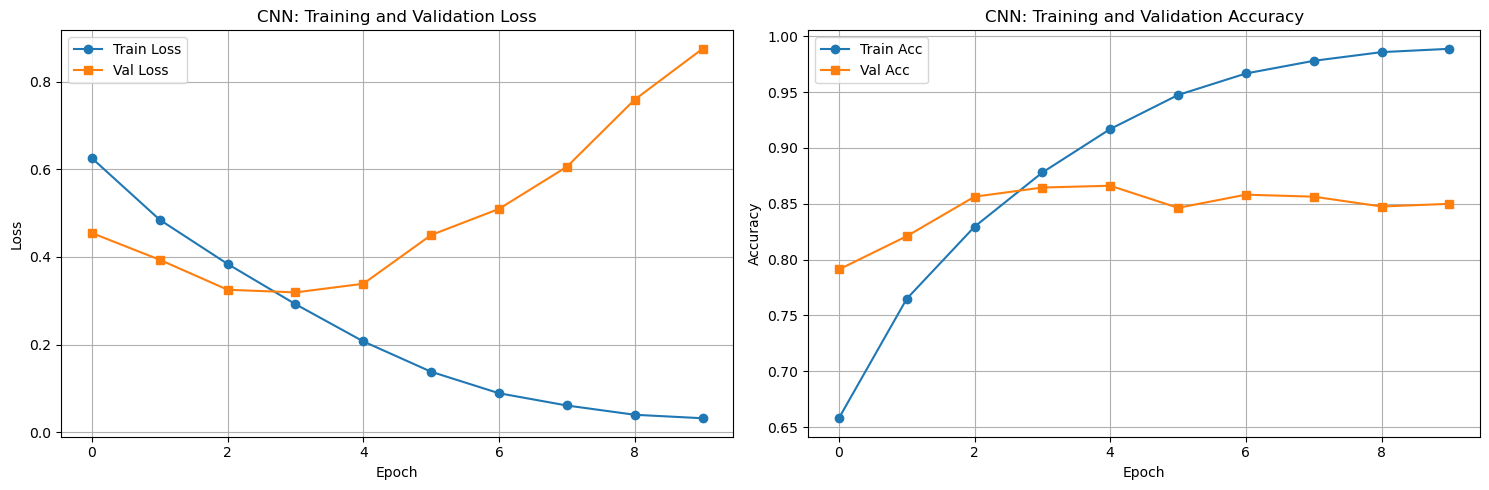

✅ CNN Training plots saved to ../experiments/plots/cnn_training_history.png


In [17]:
import matplotlib.pyplot as plt

# Plot CNN training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history_cnn['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history_cnn['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN: Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(history_cnn['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history_cnn['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN: Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ CNN Training plots saved to ../experiments/plots/cnn_training_history.png")


## 4.5 Save Baseline CNN Results

Save baseline CNN results for comparison with hyperparameter tuning results.


In [18]:
# Save baseline CNN configuration and results
cnn_baseline_config = {
    'learning_rate': 0.001,
    'num_filters': 100,
    'filter_sizes': [3, 4, 5],
    'dropout': 0.5,
    'embedding_dim': 100,
    'batch_size': 32,
    'max_length': 256
}

cnn_baseline_results = {
    'test_accuracy': test_acc_cnn,
    'test_loss': avg_test_loss_cnn,
    'best_val_accuracy': best_val_acc_cnn,
    'best_val_loss': best_val_loss_cnn,
    'final_epoch': len(history_cnn['val_acc'])
}

print("📊 Baseline CNN Configuration:")
for key, value in cnn_baseline_config.items():
    print(f"  {key}: {value}")

print("\n📊 Baseline CNN Results:")
for key, value in cnn_baseline_results.items():
    print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

print("\n✅ Baseline saved for comparison")


📊 Baseline CNN Configuration:
  learning_rate: 0.001
  num_filters: 100
  filter_sizes: [3, 4, 5]
  dropout: 0.5
  embedding_dim: 100
  batch_size: 32
  max_length: 256

📊 Baseline CNN Results:
  test_accuracy: 0.8452
  test_loss: 0.9043
  best_val_accuracy: 0.8662
  best_val_loss: 50.0967
  final_epoch: 10

✅ Baseline saved for comparison


## 4.6 CNN Hyperparameter Tuning

Tune hyperparameters following ground rules:
- Fixed seed + single validation set
- Early stop on val metric (patience 3-5)
- Save best weights
- 2-3 epochs for scouting runs
- Full training only for finalists
- Gradient clipping (1.0) to prevent bad LRs from nuking runs


In [19]:
# Set fixed seed for reproducibility (already done at top, but ensuring consistency)
seed_everything(42)
print("✅ Seed fixed to 42 for hyperparameter tuning")

# Use fixed validation set (already split, so we're good)
print(f"✅ Using fixed validation set: {len(val_texts)} samples")

# Define hyperparameter search space for CNN
cnn_hyperparameter_space = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.002, 0.005],
    'num_filters': [50, 75, 100, 150, 200],
    'filter_sizes': [[3, 4, 5], [2, 3, 4], [3, 4], [4, 5], [2, 3, 4, 5]],
    'dropout': [0.3, 0.4, 0.5, 0.6]
}

print("\n🔍 CNN Hyperparameter Search Space:")
for param, values in cnn_hyperparameter_space.items():
    print(f"  {param}: {values}")

# Calculate total combinations
total_cnn_combinations = 1
for values in cnn_hyperparameter_space.values():
    total_cnn_combinations *= len(values)
print(f"\n📊 Total combinations: {total_cnn_combinations}")
print("⚠️ This is too many for exhaustive search, will use random/grid sampling")


✅ Seed fixed to 42 for hyperparameter tuning
✅ Using fixed validation set: 5000 samples

🔍 CNN Hyperparameter Search Space:
  learning_rate: [0.0001, 0.0005, 0.001, 0.002, 0.005]
  num_filters: [50, 75, 100, 150, 200]
  filter_sizes: [[3, 4, 5], [2, 3, 4], [3, 4], [4, 5], [2, 3, 4, 5]]
  dropout: [0.3, 0.4, 0.5, 0.6]

📊 Total combinations: 500
⚠️ This is too many for exhaustive search, will use random/grid sampling


### 4.6.1 Create Training Function with Ground Rules

Training function with gradient clipping, early stopping, and best weight saving.


In [22]:
import copy

def train_cnn_with_config(config, train_loader, val_loader, device, 
                          scouting_epochs=3, full_epochs=20, 
                          patience=4, gradient_clip=1.0, 
                          save_best=True, run_name=""):
    """
    Train CNN with given hyperparameters following ground rules.
    
    Args:
        config: Dict with hyperparameters (learning_rate, num_filters, filter_sizes, dropout)
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        device: Torch device
        scouting_epochs: Number of epochs for scouting run (2-3)
        full_epochs: Number of epochs for full training
        patience: Early stopping patience (3-5)
        gradient_clip: Gradient clipping value
        save_best: Whether to save best weights
        run_name: Name for saving weights
    
    Returns:
        Dictionary with training results
    """
    # Initialize model with config
    model = CNNModel(
        vocab_size=vocab_size,
        embedding_dim=100,  # Fixed for now
        num_filters=config['num_filters'],
        filter_sizes=config['filter_sizes'],
        num_classes=2,
        dropout=config['dropout']
    ).to(device)
    
    optimizer = Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    
    # Determine if this is a scouting run or full training
    is_scouting = scouting_epochs < full_epochs
    max_epochs = scouting_epochs if is_scouting else full_epochs
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            # GRADIENT CLIPPING (Ground Rule)
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Early stopping check (Ground Rule)
        improved = False
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            improved = True
            # Save best weights (Ground Rule)
            if save_best:
                best_weights = copy.deepcopy(model.state_dict())
        
        if val_loss < best_val_loss - 0.0001:
            best_val_loss = avg_val_loss
            improved = True
        
        if improved:
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            break
    
    # Load best weights if saved
    if best_weights is not None and save_best:
        model.load_state_dict(best_weights)
    
    return {
        'config': config,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_loss,
        'final_val_acc': val_acc,
        'final_val_loss': avg_val_loss,
        'epochs_trained': len(history['val_acc']),
        'history': history,
        'model_state': model.state_dict() if save_best else None
    }

print("✅ CNN Training function created with ground rules:")
print("  ✓ Gradient clipping (1.0)")
print("  ✓ Early stopping (patience 3-5)")
print("  ✓ Best weight saving")
print("  ✓ Scouting vs full training modes")


✅ CNN Training function created with ground rules:
  ✓ Gradient clipping (1.0)
  ✓ Early stopping (patience 3-5)
  ✓ Best weight saving
  ✓ Scouting vs full training modes


### 4.6.2 Scouting Runs (2-3 Epochs)

Quick passes to identify promising configurations.


In [25]:
# Create a minimal set of configurations for scouting
# Focused on most promising configs based on initial results
# CNN is much slower than LSTM, so we use a minimal set
import random
random.seed(42)

# Minimal config list - only the most promising configurations
# Based on initial results: LR=0.002 with filters=100 performed best (0.8662)
cnn_scout_configs = [
    # Best performing from initial runs
    {'learning_rate': 0.002, 'num_filters': 100, 'filter_sizes': [3, 4, 5], 'dropout': 0.5},  # Best: 0.8662
    
    # Variations around best performer
    {'learning_rate': 0.001, 'num_filters': 100, 'filter_sizes': [3, 4, 5], 'dropout': 0.5},  # Baseline: 0.8494
    {'learning_rate': 0.002, 'num_filters': 75, 'filter_sizes': [3, 4, 5], 'dropout': 0.5},   # Try fewer filters with best LR
    {'learning_rate': 0.0015, 'num_filters': 100, 'filter_sizes': [3, 4, 5], 'dropout': 0.5}, # Between best and baseline
    
    # Filter size variations with best LR
    {'learning_rate': 0.002, 'num_filters': 100, 'filter_sizes': [2, 3, 4], 'dropout': 0.5},
    {'learning_rate': 0.002, 'num_filters': 100, 'filter_sizes': [4, 5], 'dropout': 0.5},
    
    # Dropout variation with best config
    {'learning_rate': 0.002, 'num_filters': 100, 'filter_sizes': [3, 4, 5], 'dropout': 0.4},
]

print(f"🔍 Running {len(cnn_scout_configs)} CNN scouting runs (2 epochs each)...")
print("⚠️ Using minimal config set - only most promising configurations")
print("Expected time: ~{:.1f} minutes total (about {:.1f} min per config)".format(len(cnn_scout_configs) * 1.5, 1.5))

# Check if we have partial results to continue from
# If you interrupted and want to continue, uncomment and modify the start_index
start_index = 0  # Change to 5 if you want to continue from run 5
# Uncomment the line below if continuing:
# start_index = len(cnn_scouting_results) if 'cnn_scouting_results' in locals() else 0

cnn_scouting_results = []
for i, config in enumerate(cnn_scout_configs[start_index:], start=start_index+1):
    print(f"\n{'='*60}")
    print(f"CNN Scouting Run {i}/{len(cnn_scout_configs)}")
    print(f"Config: {config}")
    print(f"{'='*60}")
    
    try:
        result = train_cnn_with_config(
            config=config,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            scouting_epochs=2,  # Reduced from 3 to 2 for speed
            full_epochs=20,
            patience=4,
            gradient_clip=1.0,
            save_best=True,
            run_name=f"cnn_scout_{i}"
        )
        
        result['run_id'] = i
        cnn_scouting_results.append(result)
        
        print(f"✅ Best Val Acc: {result['best_val_acc']:.4f} | Epochs: {result['epochs_trained']}")
    except KeyboardInterrupt:
        print(f"\n⚠️ Interrupted at run {i}. Partial results saved.")
        print(f"You can continue by setting start_index = {i} in the next run.")
        break

print("\n" + "="*60)
if len(cnn_scouting_results) == len(cnn_scout_configs):
    print("✅ CNN Scouting runs complete!")
else:
    print(f"⚠️ Partial completion: {len(cnn_scouting_results)}/{len(cnn_scout_configs)} runs completed")
    print("You can use the partial results or continue from where you left off.")
print("="*60)


🔍 Running 7 CNN scouting runs (2 epochs each)...
⚠️ Using minimal config set - only most promising configurations
Expected time: ~10.5 minutes total (about 1.5 min per config)

CNN Scouting Run 1/7
Config: {'learning_rate': 0.002, 'num_filters': 100, 'filter_sizes': [3, 4, 5], 'dropout': 0.5}
✅ Best Val Acc: 0.8500 | Epochs: 2

CNN Scouting Run 2/7
Config: {'learning_rate': 0.001, 'num_filters': 100, 'filter_sizes': [3, 4, 5], 'dropout': 0.5}
✅ Best Val Acc: 0.8270 | Epochs: 2

CNN Scouting Run 3/7
Config: {'learning_rate': 0.002, 'num_filters': 75, 'filter_sizes': [3, 4, 5], 'dropout': 0.5}
✅ Best Val Acc: 0.8482 | Epochs: 2

CNN Scouting Run 4/7
Config: {'learning_rate': 0.0015, 'num_filters': 100, 'filter_sizes': [3, 4, 5], 'dropout': 0.5}
✅ Best Val Acc: 0.8410 | Epochs: 2

CNN Scouting Run 5/7
Config: {'learning_rate': 0.002, 'num_filters': 100, 'filter_sizes': [2, 3, 4], 'dropout': 0.5}
✅ Best Val Acc: 0.8452 | Epochs: 2

CNN Scouting Run 6/7
Config: {'learning_rate': 0.002, 'num

### 4.6.3 Analyze Scouting Results and Identify Finalists


In [26]:
# Analyze CNN scouting results
cnn_scout_df = pd.DataFrame([
    {
        'Run': r['run_id'],
        'LR': r['config']['learning_rate'],
        'Filters': r['config']['num_filters'],
        'Filter_Sizes': str(r['config']['filter_sizes']),
        'Dropout': r['config']['dropout'],
        'Val Acc': r['best_val_acc'],
        'Val Loss': r['best_val_loss'],
        'Epochs': r['epochs_trained']
    }
    for r in cnn_scouting_results
])

# Sort by validation accuracy
cnn_scout_df = cnn_scout_df.sort_values('Val Acc', ascending=False)

print("📊 CNN Scouting Results (sorted by Val Accuracy):")
print(cnn_scout_df.to_string(index=False))

# Compare with baseline
cnn_baseline_val_acc = cnn_baseline_results['best_val_accuracy']
print(f"\n📊 Baseline CNN Val Accuracy: {cnn_baseline_val_acc:.4f}")
print(f"📊 Best CNN Scouting Val Accuracy: {cnn_scout_df['Val Acc'].max():.4f}")
cnn_improvement = cnn_scout_df['Val Acc'].max() - cnn_baseline_val_acc
print(f"📊 Improvement: {cnn_improvement:+.4f}")

# Identify finalists (top N or those better than baseline)
top_n_cnn = 3
cnn_finalists = cnn_scout_df.head(top_n_cnn)
print(f"\n🏆 Top {top_n_cnn} CNN Finalists Selected for Full Training:")
print(cnn_finalists[['Run', 'LR', 'Filters', 'Filter_Sizes', 'Dropout', 'Val Acc']].to_string(index=False))


📊 CNN Scouting Results (sorted by Val Accuracy):
 Run     LR  Filters Filter_Sizes  Dropout  Val Acc  Val Loss  Epochs
   7 0.0020      100    [3, 4, 5]      0.4   0.8512  0.523825       2
   1 0.0020      100    [3, 4, 5]      0.5   0.8500  0.536675       2
   3 0.0020       75    [3, 4, 5]      0.5   0.8482  0.488938       2
   5 0.0020      100    [2, 3, 4]      0.5   0.8452  0.428272       2
   4 0.0015      100    [3, 4, 5]      0.5   0.8410  0.450519       2
   2 0.0010      100    [3, 4, 5]      0.5   0.8270  0.470586       2
   6 0.0020      100       [4, 5]      0.5   0.8172  0.439478       2

📊 Baseline CNN Val Accuracy: 0.8662
📊 Best CNN Scouting Val Accuracy: 0.8512
📊 Improvement: -0.0150

🏆 Top 3 CNN Finalists Selected for Full Training:
 Run    LR  Filters Filter_Sizes  Dropout  Val Acc
   7 0.002      100    [3, 4, 5]      0.4   0.8512
   1 0.002      100    [3, 4, 5]      0.5   0.8500
   3 0.002       75    [3, 4, 5]      0.5   0.8482


### 4.6.4 Full Training on Finalists

Train finalist configurations with full epochs (20) to get final results.


In [ ]:
# Run full training on CNN finalists
print(f"🚀 Running full training on {len(cnn_finalists)} CNN finalists (20 epochs max)...")
print("This will take longer but gives final results\n")

cnn_final_results = []
for idx, row in cnn_finalists.iterrows():
    run_id = int(row['Run'])
    # Parse filter_sizes from string back to list
    filter_sizes_str = row['Filter_Sizes']
    import ast
    filter_sizes = ast.literal_eval(filter_sizes_str)
    
    config = {
        'learning_rate': row['LR'],
        'num_filters': int(row['Filters']),
        'filter_sizes': filter_sizes,
        'dropout': row['Dropout']
    }
    
    print(f"\n{'='*60}")
    print(f"CNN Full Training - Finalist {run_id}")
    print(f"Config: {config}")
    print(f"{'='*60}")
    
    result = train_cnn_with_config(
        config=config,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        scouting_epochs=3,
        full_epochs=20,
        patience=4,
        gradient_clip=1.0,
        save_best=True,
        run_name=f"cnn_finalist_{run_id}"
    )
    
    result['run_id'] = run_id
    cnn_final_results.append(result)
    
    print(f"✅ Best Val Acc: {result['best_val_acc']:.4f} | Epochs: {result['epochs_trained']}")

print("\n" + "="*60)
print("✅ CNN Full training complete!")
print("="*60)


### 4.6.5 Evaluate Best CNN Model on Test Set


In [ ]:
# Find best CNN configuration from final results
cnn_best_result = max(cnn_final_results, key=lambda x: x['best_val_acc'])
cnn_best_config = cnn_best_result['config']

print("🏆 Best CNN Configuration Found:")
for key, value in cnn_best_config.items():
    print(f"  {key}: {value}")
print(f"  Best Val Accuracy: {cnn_best_result['best_val_acc']:.4f}")

# Initialize and load best CNN model
cnn_best_model = CNNModel(
    vocab_size=vocab_size,
    embedding_dim=100,
    num_filters=cnn_best_config['num_filters'],
    filter_sizes=cnn_best_config['filter_sizes'],
    num_classes=2,
    dropout=cnn_best_config['dropout']
).to(device)

if cnn_best_result['model_state'] is not None:
    cnn_best_model.load_state_dict(cnn_best_result['model_state'])
    print("✅ Loaded best CNN weights from training")

# Evaluate on test set
cnn_best_model.eval()
test_loss_cnn_tuned = 0.0
test_correct_cnn_tuned = 0
test_total_cnn_tuned = 0
all_predictions_cnn_tuned = []
all_labels_cnn_tuned = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Evaluating tuned CNN on test set")
    for batch in test_pbar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = cnn_best_model(input_ids)
        loss = criterion_cnn(outputs, labels)
        
        test_loss_cnn_tuned += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct_cnn_tuned += (predictions == labels).sum().item()
        test_total_cnn_tuned += labels.size(0)
        
        all_predictions_cnn_tuned.extend(predictions.cpu().numpy())
        all_labels_cnn_tuned.extend(labels.cpu().numpy())

avg_test_loss_cnn_tuned = test_loss_cnn_tuned / len(test_loader)
test_acc_cnn_tuned = test_correct_cnn_tuned / test_total_cnn_tuned

print(f"\n📊 Tuned CNN Model Test Set Results:")
print(f"  Test Loss: {avg_test_loss_cnn_tuned:.4f}")
print(f"  Test Accuracy: {test_acc_cnn_tuned:.4f} ({test_correct_cnn_tuned}/{test_total_cnn_tuned})")


### 4.6.6 Compare Baseline vs Tuned CNN


In [ ]:
# Compare baseline vs tuned CNN
cnn_comparison_tuning = pd.DataFrame({
    'Model': ['Baseline CNN', 'Tuned CNN'],
    'Test Accuracy': [cnn_baseline_results['test_accuracy'], test_acc_cnn_tuned],
    'Test Loss': [cnn_baseline_results['test_loss'], avg_test_loss_cnn_tuned],
    'Val Accuracy': [cnn_baseline_results['best_val_accuracy'], cnn_best_result['best_val_acc']],
    'Learning Rate': [cnn_baseline_config['learning_rate'], cnn_best_config['learning_rate']],
    'Num Filters': [cnn_baseline_config['num_filters'], cnn_best_config['num_filters']],
    'Filter Sizes': [str(cnn_baseline_config['filter_sizes']), str(cnn_best_config['filter_sizes'])],
    'Dropout': [cnn_baseline_config['dropout'], cnn_best_config['dropout']]
})

print("📊 Baseline vs Tuned CNN Comparison:\n")
print(cnn_comparison_tuning.to_string(index=False))

# Calculate improvement
cnn_test_improvement = test_acc_cnn_tuned - cnn_baseline_results['test_accuracy']
cnn_val_improvement = cnn_best_result['best_val_acc'] - cnn_baseline_results['best_val_accuracy']

print(f"\n📈 Improvements:")
print(f"  Test Accuracy: {cnn_test_improvement:+.4f} ({cnn_test_improvement*100:+.2f}%)")
print(f"  Val Accuracy: {cnn_val_improvement:+.4f} ({cnn_val_improvement*100:+.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test accuracy comparison
axes[0].bar(['Baseline', 'Tuned'], 
            [cnn_baseline_results['test_accuracy'], test_acc_cnn_tuned],
            color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Baseline vs Tuned CNN: Test Accuracy')
axes[0].set_ylim([0, 1])
for i, v in enumerate([cnn_baseline_results['test_accuracy'], test_acc_cnn_tuned]):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Validation accuracy during training
axes[1].plot(range(1, len(history_cnn['val_acc']) + 1), history_cnn['val_acc'], 
            label='Baseline', marker='o', color='#e74c3c')
axes[1].plot(range(1, len(cnn_best_result['history']['val_acc']) + 1), 
            cnn_best_result['history']['val_acc'],
            label='Tuned', marker='s', color='#2ecc71')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy: Baseline vs Tuned CNN')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/cnn_tuning_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ CNN Comparison plots saved to ../experiments/plots/cnn_tuning_comparison.png")


## 5. Compare Baseline Models

Compare LSTM and CNN performance side by side.


In [22]:
# Compare LSTM and CNN models
comparison_data = {
    'Model': ['LSTM', 'CNN'],
    'Test Accuracy': [test_acc, test_acc_cnn],
    'Test Loss': [avg_test_loss, avg_test_loss_cnn],
    'Best Val Accuracy': [best_val_acc, best_val_acc_cnn],
    'Parameters': [
        sum(p.numel() for p in lstm_model.parameters()),
        sum(p.numel() for p in cnn_model.parameters())
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("📊 Baseline Models Comparison:\n")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test accuracy comparison
axes[0].bar(['LSTM', 'CNN'], [test_acc, test_acc_cnn], color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0, 1])
for i, v in enumerate([test_acc, test_acc_cnn]):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Training curves comparison
epochs_lstm = range(1, len(history['val_acc']) + 1)
epochs_cnn = range(1, len(history_cnn['val_acc']) + 1)
axes[1].plot(epochs_lstm, history['val_acc'], label='LSTM Val Acc', marker='o')
axes[1].plot(epochs_cnn, history_cnn['val_acc'], label='CNN Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy: LSTM vs CNN')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/baseline_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison plots saved to ../experiments/plots/baseline_models_comparison.png")


NameError: name 'test_acc_cnn' is not defined

## 6. Train BiLSTM with Attention Model

BiLSTM with attention mechanism combines bidirectional LSTM with attention to focus on important parts of the text. This often performs better than standard LSTM.


In [28]:
# Initialize BiLSTM with Attention model
# Attention mechanism helps the model focus on important words/phrases
bilstm_attn_model = BiLSTMWithAttention(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    num_classes=2,
    dropout=0.2
).to(device)

print(f"✅ BiLSTM+Attention Model initialized")
print(f"Model parameters: {sum(p.numel() for p in bilstm_attn_model.parameters()):,}")
print(f"Features: Bidirectional LSTM + Multi-head Attention (8 heads)")


✅ BiLSTM+Attention Model initialized
Model parameters: 11,004,966
Features: Bidirectional LSTM + Multi-head Attention (8 heads)


### 6.1 Training Setup for BiLSTM+Attention


In [29]:
# Setup training components for BiLSTM+Attention
optimizer_bilstm = Adam(bilstm_attn_model.parameters(), lr=0.001)
criterion_bilstm = nn.CrossEntropyLoss()

# Training parameters (same as other models)
num_epochs_bilstm = 20
patience_bilstm = 5
min_delta_bilstm = 0.0001

print(f"BiLSTM+Attention Training parameters:")
print(f"  Epochs: {num_epochs_bilstm}")
print(f"  Early stopping patience: {patience_bilstm} epochs")
print(f"  Learning rate: {optimizer_bilstm.param_groups[0]['lr']}")
print(f"  Batch size: {batch_size}")
print(f"  Device: {device}")


BiLSTM+Attention Training parameters:
  Epochs: 20
  Early stopping patience: 5 epochs
  Learning rate: 0.001
  Batch size: 32
  Device: mps


### 6.2 BiLSTM+Attention Training Loop


In [30]:
# BiLSTM+Attention Training history
history_bilstm = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc_bilstm = 0.0
best_val_loss_bilstm = float('inf')
patience_counter_bilstm = 0
early_stopped_bilstm = False

print("Starting BiLSTM+Attention training...\n")

for epoch in range(num_epochs_bilstm):
    start_time = time.time()
    
    # Training phase
    bilstm_attn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs_bilstm} [Train]")
    for batch in train_pbar:
        optimizer_bilstm.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = bilstm_attn_model(input_ids)
        loss = criterion_bilstm(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer_bilstm.step()
        
        # Statistics
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    bilstm_attn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs_bilstm} [Val]")
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = bilstm_attn_model(input_ids)
            loss = criterion_bilstm(outputs, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Update history
    history_bilstm['train_loss'].append(avg_train_loss)
    history_bilstm['train_acc'].append(train_acc)
    history_bilstm['val_loss'].append(avg_val_loss)
    history_bilstm['val_acc'].append(val_acc)
    
    # Early stopping check
    improved = False
    if val_acc > best_val_acc_bilstm:
        best_val_acc_bilstm = val_acc
        improved = True
    
    if val_loss < best_val_loss_bilstm - min_delta_bilstm:
        best_val_loss_bilstm = val_loss
        improved = True
    
    # Reset patience counter if we improved, otherwise increment
    if improved:
        patience_counter_bilstm = 0
    else:
        patience_counter_bilstm += 1
    
    elapsed_time = time.time() - start_time
    
    print(f"\nEpoch {epoch+1}/{num_epochs_bilstm} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Best Val Acc: {best_val_acc_bilstm:.4f} | Best Val Loss: {best_val_loss_bilstm:.4f}")
    print(f"  Time: {elapsed_time:.2f}s")
    
    if patience_counter_bilstm >= patience_bilstm:
        early_stopped_bilstm = True
        print(f"\n⚠️ Early stopping triggered! No improvement for {patience_bilstm} epochs.")
        print(f"Stopping training at epoch {epoch+1}")
        break
    
    print()

if not early_stopped_bilstm:
    print("✅ BiLSTM+Attention Training complete! Reached maximum epochs.")
else:
    print(f"✅ BiLSTM+Attention Training stopped early at epoch {epoch+1} (best val acc: {best_val_acc_bilstm:.4f})")


Starting BiLSTM+Attention training...



Epoch 1/20 [Val]: 100%|██████████| 157/157 [00:07<00:00, 21.67it/s, loss=0.6239, acc=0.8384]



Epoch 1/20 Summary:
  Train Loss: 0.4458 | Train Acc: 0.7867
  Val Loss: 0.3714 | Val Acc: 0.8384
  Best Val Acc: 0.8384 | Best Val Loss: 58.3036
  Time: 165.69s



Epoch 2/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.26it/s, loss=0.6570, acc=0.8844]



Epoch 2/20 Summary:
  Train Loss: 0.2443 | Train Acc: 0.9042
  Val Loss: 0.2799 | Val Acc: 0.8844
  Best Val Acc: 0.8844 | Best Val Loss: 43.9378
  Time: 157.42s



Epoch 3/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.71it/s, loss=0.8569, acc=0.8850]



Epoch 3/20 Summary:
  Train Loss: 0.1311 | Train Acc: 0.9515
  Val Loss: 0.3140 | Val Acc: 0.8850
  Best Val Acc: 0.8850 | Best Val Loss: 43.9378
  Time: 155.28s



Epoch 4/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.34it/s, loss=1.0547, acc=0.8784]



Epoch 4/20 Summary:
  Train Loss: 0.0599 | Train Acc: 0.9799
  Val Loss: 0.3870 | Val Acc: 0.8784
  Best Val Acc: 0.8850 | Best Val Loss: 43.9378
  Time: 156.48s



Epoch 5/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.65it/s, loss=2.2831, acc=0.8858]



Epoch 5/20 Summary:
  Train Loss: 0.0260 | Train Acc: 0.9915
  Val Loss: 0.6464 | Val Acc: 0.8858
  Best Val Acc: 0.8858 | Best Val Loss: 43.9378
  Time: 155.35s



Epoch 6/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.88it/s, loss=2.0661, acc=0.8850]



Epoch 6/20 Summary:
  Train Loss: 0.0176 | Train Acc: 0.9938
  Val Loss: 0.6844 | Val Acc: 0.8850
  Best Val Acc: 0.8858 | Best Val Loss: 43.9378
  Time: 152.07s



Epoch 7/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.71it/s, loss=2.3879, acc=0.8840]



Epoch 7/20 Summary:
  Train Loss: 0.0153 | Train Acc: 0.9950
  Val Loss: 0.6847 | Val Acc: 0.8840
  Best Val Acc: 0.8858 | Best Val Loss: 43.9378
  Time: 151.81s



Epoch 8/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.71it/s, loss=2.6312, acc=0.8812]



Epoch 8/20 Summary:
  Train Loss: 0.0138 | Train Acc: 0.9957
  Val Loss: 0.8246 | Val Acc: 0.8812
  Best Val Acc: 0.8858 | Best Val Loss: 43.9378
  Time: 153.41s



Epoch 9/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.61it/s, loss=2.4701, acc=0.8824]



Epoch 9/20 Summary:
  Train Loss: 0.0119 | Train Acc: 0.9962
  Val Loss: 0.6983 | Val Acc: 0.8824
  Best Val Acc: 0.8858 | Best Val Loss: 43.9378
  Time: 152.02s



Epoch 10/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 23.93it/s, loss=4.0219, acc=0.8828]


Epoch 10/20 Summary:
  Train Loss: 0.0099 | Train Acc: 0.9967
  Val Loss: 0.8850 | Val Acc: 0.8828
  Best Val Acc: 0.8858 | Best Val Loss: 43.9378
  Time: 150.94s

⚠️ Early stopping triggered! No improvement for 5 epochs.
Stopping training at epoch 10
✅ BiLSTM+Attention Training stopped early at epoch 10 (best val acc: 0.8858)


### 6.3 Evaluate BiLSTM+Attention on Test Set


In [31]:
# Evaluate BiLSTM+Attention on test set
bilstm_attn_model.eval()
test_loss_bilstm = 0.0
test_correct_bilstm = 0
test_total_bilstm = 0
all_predictions_bilstm = []
all_labels_bilstm = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Evaluating BiLSTM+Attention on test set")
    for batch in test_pbar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = bilstm_attn_model(input_ids)
        loss = criterion_bilstm(outputs, labels)
        
        test_loss_bilstm += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct_bilstm += (predictions == labels).sum().item()
        test_total_bilstm += labels.size(0)
        
        all_predictions_bilstm.extend(predictions.cpu().numpy())
        all_labels_bilstm.extend(labels.cpu().numpy())

avg_test_loss_bilstm = test_loss_bilstm / len(test_loader)
test_acc_bilstm = test_correct_bilstm / test_total_bilstm

print(f"\n📊 BiLSTM+Attention Test Set Results:")
print(f"  Test Loss: {avg_test_loss_bilstm:.4f}")
print(f"  Test Accuracy: {test_acc_bilstm:.4f} ({test_correct_bilstm}/{test_total_bilstm})")

# Calculate additional metrics
print(f"\n📈 BiLSTM+Attention Detailed Metrics:")
print(classification_report(all_labels_bilstm, all_predictions_bilstm, target_names=['Negative', 'Positive']))


Evaluating BiLSTM+Attention on test set: 100%|██████████| 313/313 [00:14<00:00, 21.99it/s]


📊 BiLSTM+Attention Test Set Results:
  Test Loss: 1.0006
  Test Accuracy: 0.8751 (8751/10000)

📈 BiLSTM+Attention Detailed Metrics:
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      5000
    Positive       0.87      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### 6.4 Visualize BiLSTM+Attention Training History


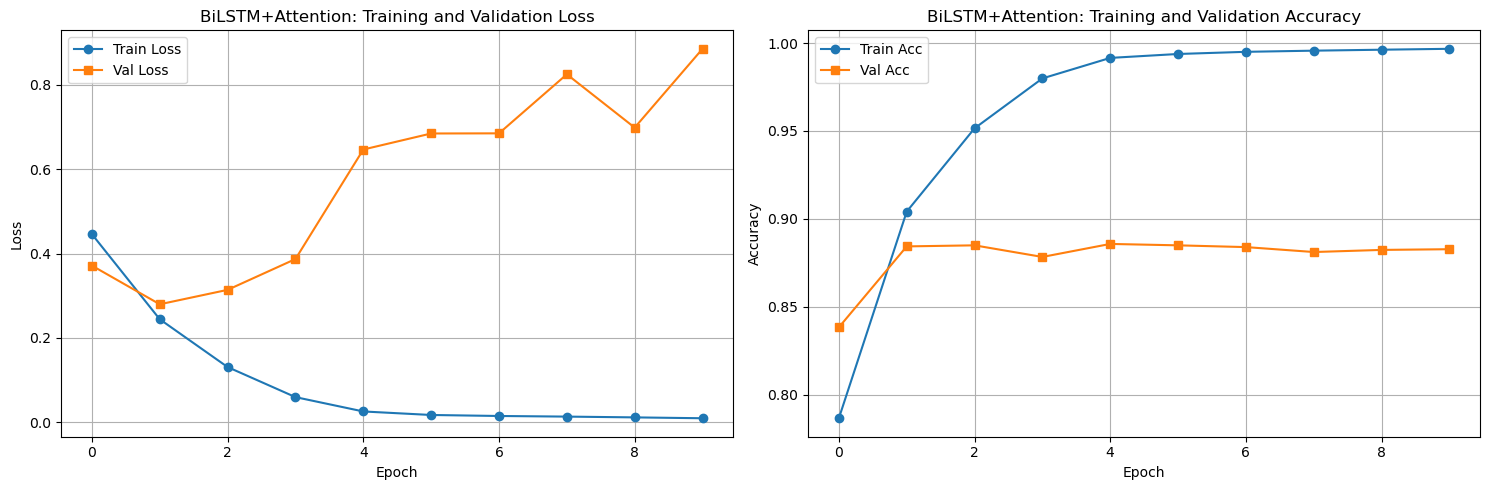

✅ BiLSTM+Attention Training plots saved to ../experiments/plots/bilstm_attention_training_history.png


In [32]:
# Plot BiLSTM+Attention training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history_bilstm['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history_bilstm['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('BiLSTM+Attention: Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(history_bilstm['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history_bilstm['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('BiLSTM+Attention: Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/bilstm_attention_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ BiLSTM+Attention Training plots saved to ../experiments/plots/bilstm_attention_training_history.png")


## 7. Final Comparison: All Baseline Models

Compare all three baseline models (LSTM, CNN, BiLSTM+Attention) side by side.


📊 All Baseline Models Comparison:

           Model  Test Accuracy  Test Loss  Best Val Accuracy  Parameters
            LSTM         0.8678   0.634521             0.8780    10741798
             CNN         0.8309   1.103356             0.8678    10231402
BiLSTM+Attention         0.8751   1.000610             0.8858    11004966


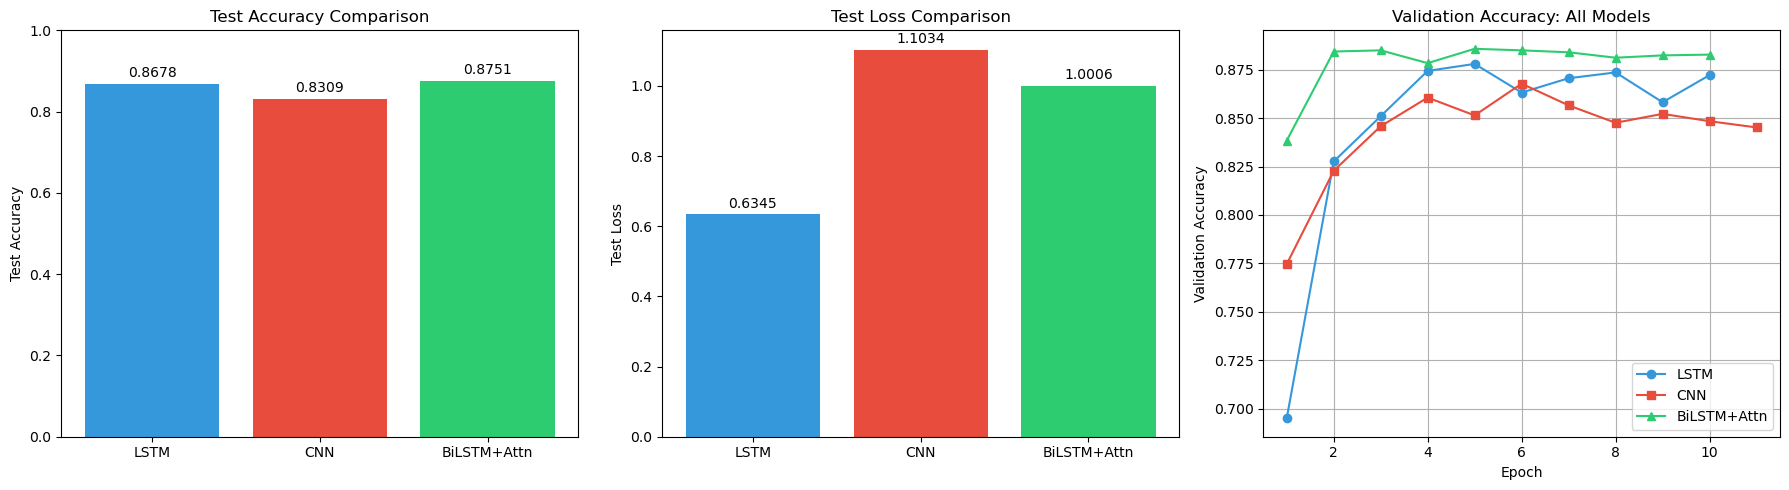


✅ Comprehensive comparison plots saved to ../experiments/plots/all_baseline_models_comparison.png

📊 BASELINE MODELS SUMMARY
🏆 Best Model: BiLSTM+Attn (Accuracy: 0.8751)

Test Accuracies:
     LSTM           : 0.8678
     CNN            : 0.8309
  👑 BiLSTM+Attn    : 0.8751


In [33]:
# Compare all baseline models
comparison_data_all = {
    'Model': ['LSTM', 'CNN', 'BiLSTM+Attention'],
    'Test Accuracy': [test_acc, test_acc_cnn, test_acc_bilstm],
    'Test Loss': [avg_test_loss, avg_test_loss_cnn, avg_test_loss_bilstm],
    'Best Val Accuracy': [best_val_acc, best_val_acc_cnn, best_val_acc_bilstm],
    'Parameters': [
        sum(p.numel() for p in lstm_model.parameters()),
        sum(p.numel() for p in cnn_model.parameters()),
        sum(p.numel() for p in bilstm_attn_model.parameters())
    ]
}

comparison_df_all = pd.DataFrame(comparison_data_all)
print("📊 All Baseline Models Comparison:\n")
print(comparison_df_all.to_string(index=False))

# Plot comprehensive comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Test accuracy comparison
models = ['LSTM', 'CNN', 'BiLSTM+Attn']
accuracies = [test_acc, test_acc_cnn, test_acc_bilstm]
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[0].bar(models, accuracies, color=colors)
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Test loss comparison
losses = [avg_test_loss, avg_test_loss_cnn, avg_test_loss_bilstm]
axes[1].bar(models, losses, color=colors)
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Test Loss Comparison')
for i, v in enumerate(losses):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Validation accuracy curves comparison
epochs_lstm = range(1, len(history['val_acc']) + 1)
epochs_cnn = range(1, len(history_cnn['val_acc']) + 1)
epochs_bilstm = range(1, len(history_bilstm['val_acc']) + 1)
axes[2].plot(epochs_lstm, history['val_acc'], label='LSTM', marker='o', color=colors[0])
axes[2].plot(epochs_cnn, history_cnn['val_acc'], label='CNN', marker='s', color=colors[1])
axes[2].plot(epochs_bilstm, history_bilstm['val_acc'], label='BiLSTM+Attn', marker='^', color=colors[2])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Validation Accuracy')
axes[2].set_title('Validation Accuracy: All Models')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/all_baseline_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comprehensive comparison plots saved to ../experiments/plots/all_baseline_models_comparison.png")

# Summary
print("\n" + "="*60)
print("📊 BASELINE MODELS SUMMARY")
print("="*60)
best_model_idx = np.argmax(accuracies)
print(f"🏆 Best Model: {models[best_model_idx]} (Accuracy: {accuracies[best_model_idx]:.4f})")
print(f"\nTest Accuracies:")
for model, acc in zip(models, accuracies):
    marker = "👑" if model == models[best_model_idx] else "  "
    print(f"  {marker} {model:15s}: {acc:.4f}")
print("="*60)
